In [5]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
ELEC_FILE='electricity.csv'
MODEL_FILE='Model'  # will be used later to save models

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
#from statsmodels.tsa.arima.model import ARIMA
#from pmdarima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [7]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda
def fix_date_type(panda):
    # Convert the given timestamp column to the pandas datetime data type.
    panda['timestamp'] = pd.to_datetime(panda['timestamp'], infer_datetime_format = True)
    indexed = panda.set_index(['timestamp'])
    return indexed

In [8]:
elec_df = read_zip_to_panda(ZIP_PATH,ELEC_FILE)
elec_df = fix_date_type(elec_df)
elec_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17544 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Columns: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
dtypes: float64(1578)
memory usage: 211.3 MB


In [9]:
elec_df = elec_df['Eagle_assembly_Portia'] #['1-1-2016':'12-31-2016']
building = elec_df
building = building.replace( 0,  4)
elec_df.describe()

count    17544.000000
mean       129.481377
std         55.910261
min          0.000000
25%         85.700000
50%        113.868550
75%        163.129375
max        354.718700
Name: Eagle_assembly_Portia, dtype: float64

## Checking the Stationarity

In [10]:
#Checking the Stationarity: series that has a constant mean

#Perform Building Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n the test statistic is less than critical value, reject the null hypothesis')
dftest = adfuller(building, autolag = 'AIC') #AIC gives the information about time series 

dfoutput= pd.Series (dftest[0:4], index= ['Test Statistic','p-value: \n p-value is smaller than 0.05','#lags used', 'Number of Observations Used'])
for key, value in dftest [4].items ():
    dfoutput ['Critical Value (%s)' %key] = value

print (dfoutput)

Results of Dickey-Fuller Test: 
 the test statistic is less than critical value, reject the null hypothesis
Test Statistic                             -6.632415e+00
p-value: \n p-value is smaller than 0.05    5.671271e-09
#lags used                                  4.400000e+01
Number of Observations Used                 1.749900e+04
Critical Value (1%)                        -3.430724e+00
Critical Value (5%)                        -2.861705e+00
Critical Value (10%)                       -2.566858e+00
dtype: float64


Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

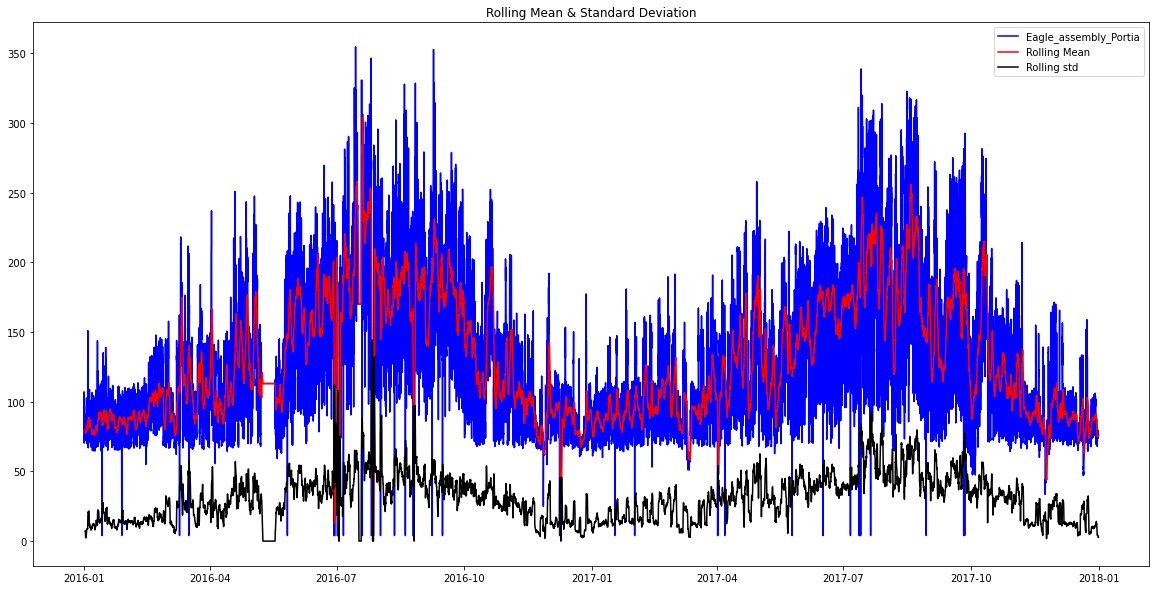

In [11]:

#Determine the rolling statistic
rolmean = building.rolling(window = 24).mean()
rolstd = building.rolling(window = 24).std()

#Checking the Stationarity
#Plot rolling statistics
plt.figure(figsize=(20,10))
orig = plt.plot (building, color = 'blue',label = 'Eagle_assembly_Portia')
mean = plt.plot (rolmean, color = 'red',label = 'Rolling Mean')
std = plt.plot (rolstd, color = 'black',label = 'Rolling std')
plt.legend (loc ='best')
plt.title ('Rolling Mean & Standard Deviation')
#plt.show (block = False)


## Determine the order of AR, I and MA component 
Using AFC autocorreclation plot and PACF partial autocorrelatioin plot

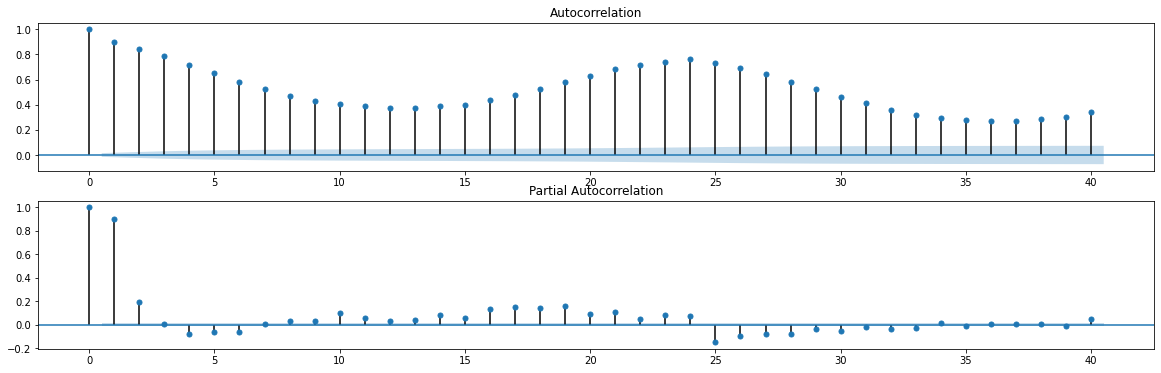

In [12]:
fig = plt.figure(figsize = (20,6))
building_acf = fig.add_subplot(211)
acf_plot = sm.graphics.tsa.plot_acf (building.dropna(),lags = 40, ax = building_acf )
building_pacf = fig.add_subplot(212)
pacf_plot = sm.graphics.tsa.plot_pacf (building.dropna(),lags = 40, ax = building_pacf )

## ARIMA


AR = p = period for autoregressive model (regression the past lag value, PACF method),
<br>
Integrated = d = order of autoregression (differenced value from present and previous to eliminate the effects of seasonality; removing the trend and seasonality to make it stationary)
<br>
MA = q = periods in moving average (present value is not only depended on the past value but the error lag value as well, use the ACF method)

In [13]:


#Build SARIMA model

model = SARIMAX(building, order=(3, 1, 5), seasonal_order=(1, 1, 0, 12)) #(1, 1, 0, 9))

results_ARIMA = model.fit()

results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:              Eagle_assembly_Portia   No. Observations:                17544
Model:             SARIMAX(3, 1, 5)x(1, 1, 0, 12)   Log Likelihood              -81291.879
Date:                            Wed, 28 Apr 2021   AIC                         162603.759
Time:                                    10:17:53   BIC                         162681.476
Sample:                                01-01-2016   HQIC                        162629.349
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8013      0.005   -162.482      0.000      -0.811      -0.792
ar.L2          0.4752      0.007     67.345      0.000       0.461       0.489
ar.L3          0.7543      0.004    172.350      0.000       0.746       0.763
ma.L1          0.3669      0.011     34.644      0.000       0.346       0.388
ma.L2         -0.9105      0.014    -66.082      0.000      -0.938      -0.883
ma.L3         -0.6699      0.006   -104.976      0.000      -0.682      -0.657
ma.L4          0.2974      0.007     41.022      0.000       0.283       0.312
ma.L5         -0.0839      0.006    -15.073      0.000      -0.095      -0.073
ar.S.L12      -0.6822      0.003   -218.717      0.000      -0.688      -0.676
sigma2       616.3837      5.676    108.588      0.000     605.258     627.509
===================================================================================
Ljung-Box (Q):                     3066.28   Jarque-Bera (JB):            212978.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -0.08
Prob(H) (two-sided):                  0.01   Kurtosis:                        20.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
pred = results_ARIMA.predict(start = len (building), end = len(building)+24*7, typ = 'levels'). rename ('ARIMA predictions')
pd.DataFrame(pred.head())


,ARIMA predictions
2018-01-01 00:00:00,76.489384
2018-01-01 01:00:00,77.249930
2018-01-01 02:00:00,70.553637
2018-01-01 03:00:00,73.102799
2018-01-01 04:00:00,73.444354


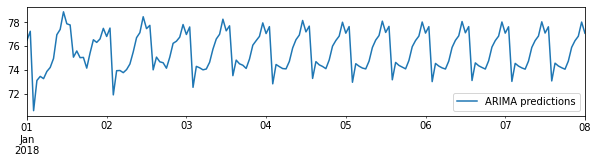

In [15]:
pred.plot(figsize = (10,2), legend = True)

## Residuals


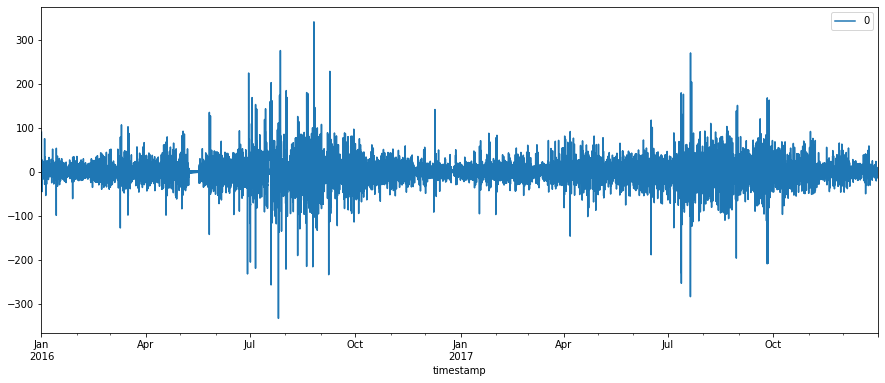

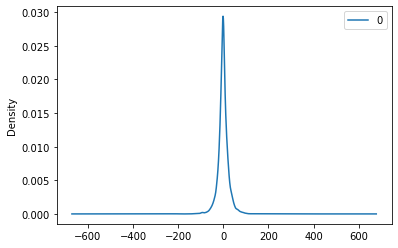

                  0
count  17544.000000
mean      -0.029877
std       24.974794
min     -333.340907
25%      -10.277472
50%       -0.613905
75%        9.961109
max      340.584656


In [16]:
# line plot of residuals
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(figsize = (15,6))
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())